In [1]:
import networkx as nx
import random
import math
import csv
import datetime
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import multiprocessing as mp
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
import numpy as np
from sklearn import linear_model
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LogisticRegression

In [2]:
def CommonNeighbors(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    return len(u_neighbors.intersection(v_neighbors))
def common_neighbors(g, edges):
    result = []
    for edge in edges:
        node_one, node_two = edge[0], edge[1]
        num_common_neighbors = 0
        try:
            neighbors_one, neighbors_two = g.neighbors(node_one), g.neighbors(node_two)
            for neighbor in neighbors_one:
                if neighbor in neighbors_two:
                    num_common_neighbors += 1
            result.append((node_one, node_two, num_common_neighbors))
        except:
            pass
    return result

In [3]:
def AdamicAdar(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    aa = 0
    for i in u_neighbors.intersection(v_neighbors):
        aa += 1 / math.log(len(g.neighbors(i)))
    return aa

In [4]:
def ResourceAllocation(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    ra = 0
    for i in u_neighbors.intersection(v_neighbors):
        ra += 1 / float(len(g.neighbors(i)))
    return ra

In [5]:
def JaccardCoefficent(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    return len(u_neighbors.intersection(v_neighbors)) / float(len(u_neighbors.union(v_neighbors)))

In [6]:
def PreferentialAttachment(u, v, g):
    return len(g.neighbors(u))*len(g.neighbors(v))

In [7]:
def AllFeatures(u,v,g1, g2):
    '''
    the change of features in two consecutive sub graphs
    '''
    try:
        cn = CommonNeighbors(u, v, g2)
        aa = AdamicAdar(u, v, g2)
        ra = ResourceAllocation(u, v, g2)
        jc = JaccardCoefficent(u, v, g2)
        pa = PreferentialAttachment(u, v, g2)

        delta_cn = cn - CommonNeighbors(u, v, g1)
        delta_aa = aa - AdamicAdar(u, v, g1)
        delta_ra = ra - ResourceAllocation(u, v, g1)
        delta_jc = jc - JaccardCoefficent(u, v, g1)
        delta_pa = pa - PreferentialAttachment(u, v, g1)
        return {"cn":cn, "aa": aa, "ra":ra, "jc":jc, "pa":pa,
            "delta_cn": delta_cn, "delta_aa": delta_aa, "delta_ra": delta_ra,
             "delta_jc": delta_jc, "delta_pa": delta_pa}
    except:
        pass

In [8]:
feature_set = [common_neighbors,
                   nx.resource_allocation_index,
                   nx.jaccard_coefficient,
                   nx.adamic_adar_index,
                   nx.preferential_attachment
                   ]

In [9]:
def produce_fake_edge(g, neg_g,num_test_edges):
    i = 0
    while i < num_test_edges:
        edge = random.sample(g.nodes(), 2)
        try:
            shortest_path = nx.shortest_path_length(g,source=edge[0],target=edge[1])
            if shortest_path >= 2:
                neg_g.add_edge(edge[0],edge[1], positive="False")
                i += 1
        except:
            pass

In [10]:
def create_graph_from_file(filename):
    print("----------------build graph--------------------")
    f = open(filename, "rb")
    g = nx.read_edgelist(f)
    return g

In [11]:
def sample_extraction(g, pos_num, neg_num, neg_mode, neg_distance=2, delete=1):
    """

    :param g:  the graph
    :param pos_num: the number of positive samples
    :param neg_num: the number of negative samples
    :param neg_distance: the distance between two nodes in negative samples
    :param delete: if delete ==0, don't delete positive edges from graph
    :return: pos_sample is a list of positive edges, neg_sample is a list of negative edges
    """

    print("----------------extract positive samples--------------------")
    # randomly select pos_num as test edges
    pos_sample = random.sample(g.edges(), pos_num)
    sample_g = nx.Graph()
    sample_g.add_edges_from(pos_sample, positive="True")
    nx.write_edgelist(sample_g, "sample_positive_" +str(pos_num)+ ".txt", data=['positive'])

    # adding non-existing edges
    print("----------------extract negative samples--------------------")
    i = 0
    neg_g = nx.Graph()
    produce_fake_edge(g,neg_g,neg_num)
    nx.write_edgelist(neg_g, "sample_negative_" +str(neg_num)+ ".txt", data=["positive"])
    neg_sample = neg_g.edges()
    neg_g.add_edges_from(pos_sample,positive="True")
    nx.write_edgelist(neg_g, "sample_combine_" +str(pos_num + neg_num)+ ".txt", data=["positive"])

    # remove the positive sample edges, the rest is the training set
    if delete == 0:
        return pos_sample, neg_sample
    else:
        g.remove_edges_from(pos_sample)
        nx.write_edgelist(g, "training.txt", data=False)

        return pos_sample, neg_sample

In [12]:
def feature_extraction(g, pos_sample, neg_sample, feature_name, model="single", combine_num=5):

    data = []
    if model == "single":
        print ("-----extract feature:", feature_name.__name__, "----------")
        preds = feature_name(g, pos_sample)
        feature = [feature_name.__name__] + [i[2] for i in preds]
        label = ["label"] + ["Pos" for i in range(len(feature))]
        preds = feature_name(g, neg_sample)
        feature1 = [i[2] for i in preds]
        feature = feature + feature1
        label = label + ["Neg" for i in range(len(feature1))]
        data = [feature, label]
        data = transpose(data)
        print("----------write the feature to file---------------")
        write_data_to_file(data, "features_" + model + "_" + feature_name.__name__ + ".csv")
    else:
        label = ["label"] + ["1" for i in range(len(pos_sample))] + ["0" for i in range(len(neg_sample))]
        for j in feature_name:
            print ("-----extract feature:", j.__name__, "----------")
            preds = j(g, pos_sample)

            feature = [j.__name__] + [i[2] for i in preds]
            preds = j(g, neg_sample)
            feature = feature + [i[2] for i in preds]
            data.append(feature)

        data.append(label)
        data = transpose(data)
        print("----------write the features to file---------------")
        write_data_to_file(data, "features_" + model + "_" + str(combine_num) + ".csv")
    return data


def write_data_to_file(data, filename):
    csvfile = open(filename, "w")
    writer = csv.writer(csvfile)
    for i in data:
        writer.writerow(i)
    csvfile.close()


def transpose(data):
    return [list(i) for i in zip(*data)]

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

In [14]:
def main(filename="twitter_combined.txt", pos_num=0.1, neg_num=0.1, model="combined", combine_num=1,
         feature_name=common_neighbors, neg_mode="hard"):
    if combine_num==2:
        pos_num=0.008;
        neg_num=0.008;
    g = create_graph_from_file(filename)
    num_edges = g.number_of_edges()
    pos_num = int(num_edges * pos_num)
    neg_num = int(num_edges * neg_num)
    pos_sample, neg_sample = sample_extraction(g, pos_num, neg_num,neg_mode)
    train_data = feature_extraction(g, pos_sample, neg_sample, feature_name, model, combine_num)
    print(pos_num,neg_num,num_edges)
    return g


In [53]:
fn="twitter_combined.txt";
cn=2;

In [16]:
#Run this line to genrate feature Set
G = main(filename=fn,model="combined",combine_num=cn, feature_name=feature_set, neg_mode="easy")

----------------build graph--------------------
----------------extract positive samples--------------------
----------------extract negative samples--------------------
-----extract feature: common_neighbors ----------
-----extract feature: resource_allocation_index ----------
-----extract feature: jaccard_coefficient ----------
-----extract feature: adamic_adar_index ----------
-----extract feature: preferential_attachment ----------
----------write the features to file---------------
10738 10738 1342310


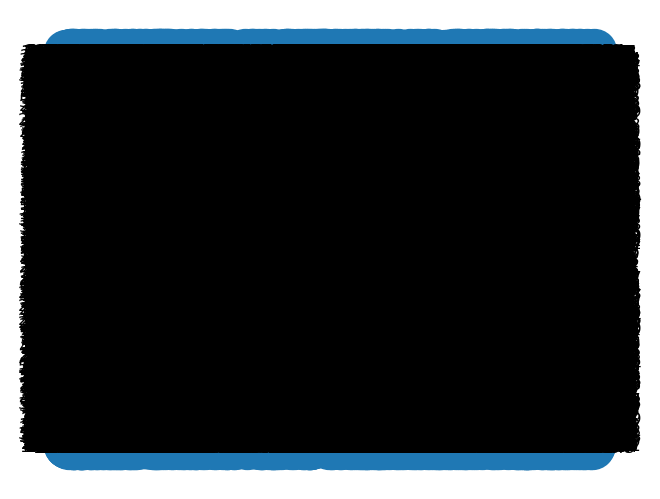

In [48]:
nx.draw(G,nx.random_layout(G))
plt.show()

In [17]:
print("No of Nodes :", end=" ")
print(len(G.nodes))
print("No of edges :", end=" ")
print(len(G.edges))

No of Nodes : 81306
No of edges : 1331572


## Density of graph

In [18]:
nx.density(G)

0.00040286060460860954

In [54]:
nx.average_degree_connectivity(G)

{280: 170.03392857142856,
 2444: 84.81587561374795,
 254: 183.06627296587928,
 710: 142.92112676056337,
 305: 144.0448087431694,
 1018: 126.6139489194499,
 116: 169.9816411238825,
 76: 164.68704565280603,
 242: 166.0383707201889,
 815: 143.57423312883435,
 595: 158.07226890756303,
 276: 214.96635610766046,
 309: 156.5177993527508,
 941: 122.07757704569607,
 69: 164.7098445595855,
 433: 160.1622401847575,
 545: 196.80366972477063,
 138: 199.10230179028133,
 530: 142.09622641509435,
 58: 161.62784645413143,
 372: 191.24551971326164,
 382: 165.73560209424085,
 267: 185.8801498127341,
 472: 205.385593220339,
 516: 128.39341085271317,
 198: 210.8151515151515,
 144: 176.42206790123456,
 60: 161.61166666666668,
 522: 175.86590038314176,
 149: 178.0679800822689,
 1043: 130.06423777564717,
 114: 167.802764486975,
 287: 191.54206072672972,
 227: 163.4908747640025,
 306: 186.06427015250546,
 403: 212.92679900744417,
 582: 130.77405498281786,
 106: 184.02520636792454,
 170: 175.80196078431374,
 41

## Degree Centrality

In [55]:
nx.degree_centrality(G)

{'214328887': 0.003443822643133878,
 '34428380': 0.030059651927925708,
 '17116707': 0.0031240391119857326,
 '28465635': 0.008732550273660905,
 '380580781': 0.0037513068076994033,
 '18996905': 0.012520755181108172,
 '221036078': 0.0014267265235840354,
 '153460275': 0.0009347518602791956,
 '107830991': 0.0029764467129942806,
 '17868918': 0.01002398376483611,
 '151338729': 0.007318123116659491,
 '222261763': 0.0033946251768033945,
 '19705747': 0.003800504274029887,
 '88323281': 0.011573703954246355,
 '19933035': 0.0008486562942008486,
 '149538028': 0.0053256257302748905,
 '158419434': 0.006703154787528442,
 '17434613': 0.0016973125884016972,
 '153226312': 0.006518664288789127,
 '364971269': 0.0007133632617920177,
 '100581193': 0.00457536436873501,
 '279787626': 0.00469835803456122,
 '113058991': 0.0032839308775598056,
 '69592091': 0.005805301026997109,
 '187773078': 0.006346473156632433,
 '406628822': 0.002435274583358957,
 '262802533': 0.001771108787897423,
 '460282402': 0.00073796199495

In [46]:
nx.closeness_centrality(G)

KeyboardInterrupt: 

In [49]:
nx.betweenness_centrality(G)

KeyboardInterrupt: 

In [56]:
r=np.loadtxt(open("features_combined_"+str(cn)+".csv", "rb"), delimiter=",", skiprows=1);

In [57]:
l,b=r.shape;
l,b

(32214, 6)

In [58]:
np.random.shuffle(r);

In [59]:
train_l=int(0.75*l)
X_train=r[0:train_l,0:b-1]
Y_train=r[0:train_l,b-1]
X_test=r[train_l:l,0:b-1]
Y_test=r[train_l:l,b-1]
X_train = normalize(X_train, axis=0, norm='max')
X_test = normalize(X_test, axis=0, norm='max')
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  
X_train.shape,X_test.shape
print(X_train,X_test,Y_train,Y_test)

[[ 1.05982097  0.06285678  0.66875483  0.00890689 -0.20799086]
 [-0.47471545  0.07257564  0.70052815 -0.039979   -0.22239802]
 [-0.47471545 -0.61929086 -0.77090525 -0.68257823 -0.24087833]
 ...
 [-0.47471545  0.29709713 -0.07479842  0.2718486  -0.0537724 ]
 [-0.47471545  1.18860186  1.30156542  0.95500021 -0.14302193]
 [-0.47471545  0.21105909  0.0664874   1.25240558  0.38317751]] [[-0.47471545 -0.18255451 -0.59223278 -0.27405517 -0.13381856]
 [-0.47471545 -0.42282096 -0.21212562 -0.2735314  -0.16032522]
 [-0.47471545  0.86367866 -0.19094556  0.15383296 -0.16939513]
 ...
 [ 3.10586952 -0.26731099  0.63320767 -0.3044435  -0.23010733]
 [-0.47471545 -0.61929086 -0.77090525 -0.68257823 -0.21905117]
 [ 1.31557704 -0.02724467  0.31849271 -0.42533252 -0.23849173]] [0. 1. 0. ... 1. 0. 1.] [1. 0. 0. ... 0. 0. 0.]


In [20]:
def mySvm(training, training_labels, testing, testing_labels):
    #Support Vector Machine
    start = datetime.datetime.now()
    clf = svm.SVC()
    clf.fit(training, training_labels)
    print ("+++++++++ Finishing training the SVM classifier ++++++++++++")
    result = clf.predict(testing)

    print ("SVM accuracy:", accuracy_score(testing_labels, result))
    #keep the time
    finish = datetime.datetime.now()
    print ((finish-start).seconds)

In [21]:
mySvm(X_train,Y_train,X_test,Y_test)

+++++++++ Finishing training the SVM classifier ++++++++++++
SVM accuracy: 0.6738266699776508
17


In [22]:
def logistic(training, training_labels, testing, testing_labels):
    clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr').fit(training, training_labels)
    start = datetime.datetime.now()
    clf.fit(training, training_labels)
    result=clf.predict(testing)
    print ("+++++++++ Finishing training the Linear classifier ++++++++++++")
    print ("Linear accuracy:", accuracy_score(testing_labels, result))
    #keep the time
    finish = datetime.datetime.now()
    print ((finish-start).seconds)

In [23]:
#Run this for Logistic Regression
logistic(X_train,Y_train,X_test,Y_test)

+++++++++ Finishing training the Linear classifier ++++++++++++
Linear accuracy: 0.6688601936925751
0


In [24]:
def ANN(training, training_labels, testing, testing_labels):
    clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(15,9), random_state=1)
    start = datetime.datetime.now()
    clf.fit(training, training_labels)
    print ("+++++++++ Finishing training the ANN classifier ++++++++++++")
    result = clf.predict(testing)

    print ("ANN accuracy:", accuracy_score(testing_labels, result))
    #keep the time
    finish = datetime.datetime.now()
    print ((finish-start).seconds)

In [25]:
ANN(X_train,Y_train,X_test,Y_test)

+++++++++ Finishing training the ANN classifier ++++++++++++
ANN accuracy: 0.6717159175564936
5


In [30]:
G.nodes()

NodeView(('214328887', '34428380', '17116707', '28465635', '380580781', '18996905', '221036078', '153460275', '107830991', '17868918', '151338729', '222261763', '19705747', '88323281', '19933035', '149538028', '158419434', '17434613', '153226312', '364971269', '100581193', '279787626', '113058991', '69592091', '187773078', '406628822', '262802533', '460282402', '280935165', '437804658', '27633075', '285312927', '131613362', '17675120', '394263193', '254839786', '204317520', '21548772', '67864340', '172883064', '270449528', '297801196', '8088112', '14925700', '124528830', '307458983', '160237722', '220368467', '54228724', '206923844', '103598216', '207594668', '21146135', '451250774', '314316607', '6581292', '31331740', '196327549', '225444667', '274153775', '35415466', '72818790', '324201646', '40981798', '430268163', '88097807', '276308596', '358775055', '15023872', '16870853', '70492333', '430313102', '299715516', '35359596', '276577539', '248883350', '157829215', '107511013', '22462

In [50]:

adamic_list = []
jaccard_list = []
common_list = []
resource_list = []
prefer_list = []
for u in ['34428380']:
    for v in G.nodes():
        if u != v and not G.has_edge(u, v):
            prefer_list.append(nx.preferential_attachment(G, [(u, v)]).__next__()[2])
            resource_list.append(nx.resource_allocation_index(G, [(u, v)]).__next__()[2])
            jaccard_coefficient = nx.jaccard_coefficient(G, [(u, v)]) 
            common_list.append(len(list(nx.common_neighbors(G, u, v))))
            jaccard_list.append(jaccard_coefficient.__next__()[2])
            adamic_ad = list(nx.adamic_adar_index(G, [(u, v)]))            
            adamic_list.append(adamic_ad[0][2])

adamic_list = [i for i in adamic_list if i != 0]
common_list = [i for i in common_list if i != 0]
jaccard_list = [i for i in jaccard_list if i != 0]
resource_list = [i for i in resource_list if i != 0]
prefer_list = [i for i in prefer_list if i != 0]


In [51]:
adamic_threshold = np.percentile(adamic_list,99)
common_threshold = np.percentile(common_list,99)
jaccard_threshold = np.percentile(jaccard_list,99)
resource_threshold = np.percentile(resource_list,99)
prefer_threshold = np.percentile(prefer_list,99)

print(adamic_threshold,common_threshold,jaccard_threshold,resource_threshold,prefer_threshold)

10.288091481758155 48.0 0.01915318628796813 0.6653798199793156 603668.0


In [52]:
potential_edges = []
# Iterate over all pairs of nodes (u, v) that are not already connected
for u in ['34428380']:
    for v in G.nodes():
        if u != v and not G.has_edge(u, v):                 
            common_neighbors = list(nx.common_neighbors(G, u, v))          
            jaccard_coefficient = nx.jaccard_coefficient(G, [(u, v)])   
            adamic_ad = list(nx.adamic_adar_index(G, [(u, v)]))   
            resource_score = nx.resource_allocation_index(G, [(u, v)]).__next__()[2]  
            prefer_score = nx.preferential_attachment(G, [(u, v)]).__next__()[2]
            resource_score = nx.resource_allocation_index(G, [(u, v)]).__next__()[2]                   
            for _, _, score in jaccard_coefficient:
                if resource_score > resource_threshold and score > jaccard_threshold and len(common_neighbors) > common_threshold and adamic_ad[0][2] > adamic_threshold and prefer_score > prefer_threshold and resource_score > resource_threshold:
                    potential_edges.append((u, v))
for edge in potential_edges:
    print("Potential edge:", edge)

Potential edge: ('34428380', '14925700')
Potential edge: ('34428380', '54228724')
Potential edge: ('34428380', '37699718')
Potential edge: ('34428380', '117674417')
Potential edge: ('34428380', '15150609')
Potential edge: ('34428380', '116498875')
Potential edge: ('34428380', '121533789')
Potential edge: ('34428380', '8163442')
Potential edge: ('34428380', '2367911')
Potential edge: ('34428380', '39056518')
Potential edge: ('34428380', '12925072')
Potential edge: ('34428380', '62513246')
Potential edge: ('34428380', '160817572')
Potential edge: ('34428380', '14230524')
Potential edge: ('34428380', '21556071')
Potential edge: ('34428380', '238260874')
Potential edge: ('34428380', '22548403')
Potential edge: ('34428380', '263838766')
Potential edge: ('34428380', '166739404')
Potential edge: ('34428380', '28706024')
Potential edge: ('34428380', '73992972')
Potential edge: ('34428380', '26604704')
Potential edge: ('34428380', '17503591')
Potential edge: ('34428380', '44473103')
Potential e